In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
#############################
## Definition of functions ##
#############################

def Chi2(observed, expected):
    """observed and expected are numpy's arrays"""
    try: #For 2-dimensional arrays
        summation = sum(sum((observed - expected)**2/expected))
        return summation
    except: #For 1-dimensional arrays
        summation = sum((observed - expected)**2/expected)
        return summation

def Min(A):
    """Return the minimun of the 3-dimensional array A"""
    mins = []
    rank_i = np.shape(A)[0]
    rank_j = np.shape(A)[1]
    for i in range(rank_i):
        for j in range(rank_j):
            mins.append(min(A[i,j,:]))
    return min(mins)

def euler(f,y0,x,args):
    """
    f: is a tuple with the system of ODEs
    y0: is a tuple with the initial conditions
    x: is the partition of the interval of integration
    args: is a tuple with the requaried parameters for f
    """
    N = len(x)-1
    h = (x[-1]-x[0])/N
    y = [y0]
    for n in range(N):
        y_nplus1 = y[n] + h*f(y[n],x[n],*args)
        y.append(y_nplus1)
    return np.array(y)

def rk4(f,y0,x,args):
    """
    f: is a tuple with the system of ODEs
    y0: is a tuple with the initial conditions
    x: is the partition of the interval of integration
    args: is a tuple with the requaried parameters for f
    """
    N = len(x)-1
    h = (x[-1]-x[0])/N
    y = [y0]
    for n in range(N):
        k1 = h*f(y[n],x[n],*args)
        k2 = h*f(y[n]+h*k1/2,x[n]+h/2,*args)
        k3 = h*f(y[n]+h*k2/2,x[n]+h/2,*args)
        k4 = h*f(y[n]+h*k3,x[n]+h,*args)
        y_nplus1 = y[n]+(k1+2*k2+2*k3+k4)/6
        y.append(y_nplus1)
    return np.array(y)

In [3]:
##################
## Loading data ##
##################

path = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/'

#Loading data confirmed
data_confirmed = np.loadtxt(path+'time_series_covid19_confirmed_global.csv',
                            dtype=str,
                            delimiter='\t')
for i in range(len(data_confirmed)):
    if 'Hubei' in data_confirmed[i]:
        break
data_confirmed = np.array(data_confirmed[i].split(',')[4:],dtype=float)

#Loading data deaths
data_deaths = np.loadtxt(path+'time_series_covid19_deaths_global.csv',
                         dtype=str,
                         delimiter='\t')
for i in range(len(data_deaths)):
    if 'Hubei' in data_deaths[i]:
        break
data_deaths = np.array(data_deaths[i].split(',')[4:],dtype=float)

#Loading data recovered
data_recovered = np.loadtxt(path+'time_series_covid19_recovered_global.csv',
                            dtype=str,
                            delimiter='\t')
for i in range(len(data_recovered)):
    if 'Hubei' in data_recovered[i]:
        break
data_recovered = np.array(data_recovered[i].split(',')[4:],dtype=float)

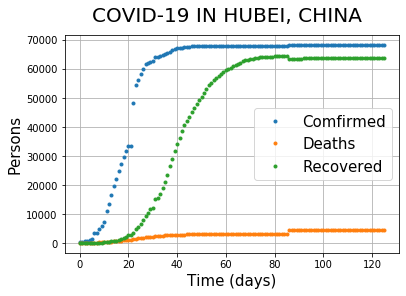

In [4]:
#############
## Graphic ##
#############

time = np.arange(len(data_recovered))

plt.suptitle('COVID-19 IN HUBEI, CHINA',fontsize=20)
plt.plot(time,data_confirmed,'.',label='Comfirmed')
plt.plot(time,data_deaths,'.',label='Deaths')
plt.plot(time,data_recovered,'.',label='Recovered')
plt.ylabel('Persons',fontsize=15)
plt.xlabel('Time (days)',fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.grid()
plt.show()

In [5]:
##########################################
## The SIR model without vital dynamics ##
##########################################

def dydt(y,t,beta,gamma,N):
    """
    S: is the stock of susceptible population
    I: is the stock of infected
    R: is the stock of removed population
    beta⁻¹: tipycal time between contacs
    gamma⁻¹: tipycal time until removal
    N: population
    """
    S, I, R = y
    return np.array([-beta*I*S/N, beta*I*S/N - gamma*I, gamma*I])

N = max(data_confirmed + data_recovered + data_deaths)
S = N - (data_confirmed + data_recovered + data_deaths)
I = data_confirmed
R = data_recovered + data_deaths

y0 = [S[0],I[0],R[0]] #Initial conditions

Solution with euler and Chi²

beta = 0.24222222222222223
gamma = 0.023333333333333334
N = 136265


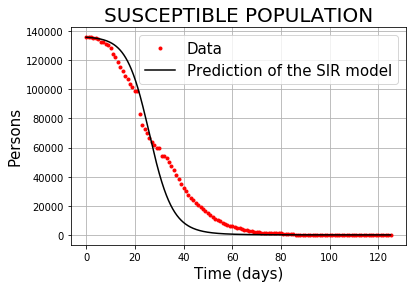

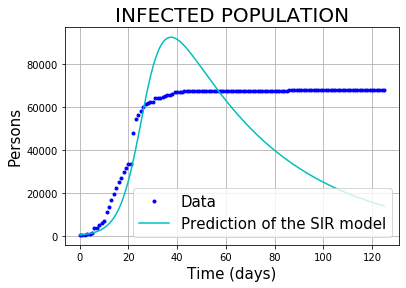

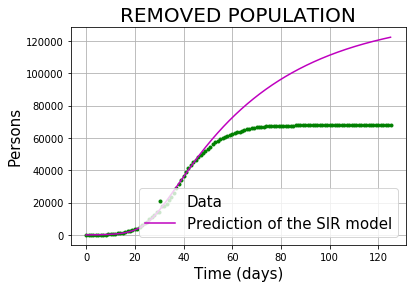

In [6]:
##################################
## Solution with euler and Chi² ##
##################################

print('Solution with euler and Chi²\n')

#Fit by chi²
steps = 10
beta = np.linspace(0.20,0.26,steps)
gamma = np.linspace(0.01,0.10,steps)
N = np.arange(N,N+steps)
shape = (steps,steps,steps)
chi2_S, chi2_I, chi2_R = np.zeros(shape), np.zeros(shape), np.zeros(shape)
for i in range(steps):
    for j in range(steps):
        for k in range(steps):
            #print('Calculating chi²:',i,j,k)
            sol = euler(dydt,y0,time,args=(beta[i],gamma[j],N[k]))
            S_expected = sol[:,0]
            chi2_S[i,j,k] = Chi2(S,S_expected)
            I_expected = sol[:,1]
            chi2_I[i,j,k] = Chi2(I,I_expected)
            R_expected = sol[:,2]
            chi2_R[i,j,k] = Chi2(R,R_expected)

chi2_S_min, chi2_I_min, chi2_R_min = Min(chi2_S), Min(chi2_I), Min(chi2_R)
beta_opt = [0,0,0]
gamma_opt = [0,0,0]
N_opt = [0,0,0]
for i in range(steps):
    for j in range(steps):
        for k in range(steps):
            #print('Calculating minimum of chi²:',i,j,k)
            if chi2_S[i,j,k] == chi2_S_min:
                beta_opt[0], gamma_opt[0], N_opt[0] = beta[i], gamma[j], N[k]
            if chi2_I[i,j,k] == chi2_I_min:
                beta_opt[1], gamma_opt[1], N_opt[1] = beta[i], gamma[j], N[k]
            if chi2_R[i,j,k] == chi2_R_min:
                beta_opt[2], gamma_opt[2], N_opt[2] = beta[i], gamma[j], N[k]
                
beta = np.mean(beta_opt)
print('beta =',beta)
gamma = np.mean(gamma_opt)
print('gamma =',gamma)
N = int(np.mean(N_opt))
print('N =',N)

np.savetxt('beta_gamma_N_euler.txt',[beta,gamma,N])

t = np.linspace(time[0],time[-1],1000)
sol = euler(dydt,y0,t,args=(beta,gamma,N))

plt.title('SUSCEPTIBLE POPULATION',fontsize=20)
plt.plot(time,S,'.r',label='Data')
plt.plot(t,sol[:,0],'k',label='Prediction of the SIR model')
plt.ylabel('Persons',fontsize=15)
plt.xlabel('Time (days)',fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.grid()
plt.show()

plt.title('INFECTED POPULATION',fontsize=20)
plt.plot(time,I,'.b',label='Data')
plt.plot(t,sol[:,1],'c',label='Prediction of the SIR model')
plt.ylabel('Persons',fontsize=15)
plt.xlabel('Time (days)',fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.grid()
plt.show()

plt.title('REMOVED POPULATION',fontsize=20)
plt.plot(time,R,'.g',label='Data')
plt.plot(t,sol[:,2],'m',label='Prediction of the SIR model')
plt.ylabel('Persons',fontsize=15)
plt.xlabel('Time (days)',fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.grid()
plt.show()

Solution with rk4 and Chi²

beta = 0.24
gamma = 0.020000000000000004
N = 136268


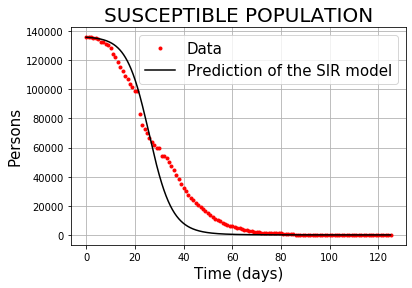

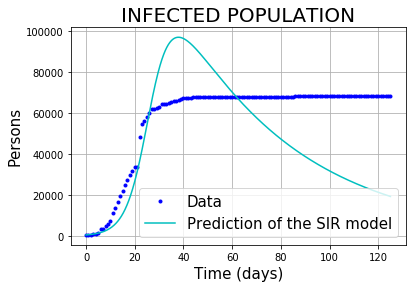

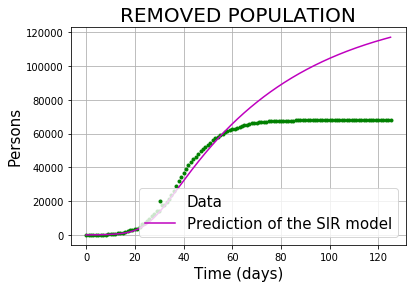

In [7]:
################################
## Solution with rk4 and Chi² ##
################################

print('Solution with rk4 and Chi²\n')

#Fit by chi²
N = max(data_confirmed + data_recovered + data_deaths)
steps = 10
beta = np.linspace(0.20,0.26,steps)
gamma = np.linspace(0.01,0.10,steps)
N = np.arange(N,N+steps)
shape = (steps,steps,steps)
chi2_S, chi2_I, chi2_R = np.zeros(shape), np.zeros(shape), np.zeros(shape)
for i in range(steps):
    for j in range(steps):
        for k in range(steps):
            #print('Calculating chi²:',i,j,k)
            sol = rk4(dydt,y0,time,args=(beta[i],gamma[j],N[k]))
            S_expected = sol[:,0]
            chi2_S[i,j,k] = Chi2(S,S_expected)
            I_expected = sol[:,1]
            chi2_I[i,j,k] = Chi2(I,I_expected)
            R_expected = sol[:,2]
            chi2_R[i,j,k] = Chi2(R,R_expected)

chi2_S_min, chi2_I_min, chi2_R_min = Min(chi2_S), Min(chi2_I), Min(chi2_R)
beta_opt = [0,0,0]
gamma_opt = [0,0,0]
N_opt = [0,0,0]
for i in range(steps):
    for j in range(steps):
        for k in range(steps):
            #print('Calculating minimum of chi²:',i,j,k)
            if chi2_S[i,j,k] == chi2_S_min:
                beta_opt[0], gamma_opt[0], N_opt[0] = beta[i], gamma[j], N[k]
            if chi2_I[i,j,k] == chi2_I_min:
                beta_opt[1], gamma_opt[1], N_opt[1] = beta[i], gamma[j], N[k]
            if chi2_R[i,j,k] == chi2_R_min:
                beta_opt[2], gamma_opt[2], N_opt[2] = beta[i], gamma[j], N[k]
                
beta = np.mean(beta_opt)
print('beta =',beta)
gamma = np.mean(gamma_opt)
print('gamma =',gamma)
N = int(np.mean(N_opt))
print('N =',N)

np.savetxt('beta_gamma_N_rk4.txt',[beta,gamma,N])

sol = rk4(dydt,y0,t,args=(beta,gamma,N))

plt.title('SUSCEPTIBLE POPULATION',fontsize=20)
plt.plot(time,S,'.r',label='Data')
plt.plot(t,sol[:,0],'k',label='Prediction of the SIR model')
plt.ylabel('Persons',fontsize=15)
plt.xlabel('Time (days)',fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.grid()
plt.show()

plt.title('INFECTED POPULATION',fontsize=20)
plt.plot(time,I,'.b',label='Data')
plt.plot(t,sol[:,1],'c',label='Prediction of the SIR model')
plt.ylabel('Persons',fontsize=15)
plt.xlabel('Time (days)',fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.grid()
plt.show()

plt.title('REMOVED POPULATION',fontsize=20)
plt.plot(time,R,'.g',label='Data')
plt.plot(t,sol[:,2],'m',label='Prediction of the SIR model')
plt.ylabel('Persons',fontsize=15)
plt.xlabel('Time (days)',fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.grid()
plt.show()

Solution with odeint and Chi²

beta = 0.24
gamma = 0.020000000000000004
N = 136268


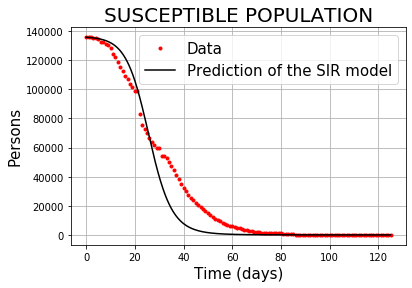

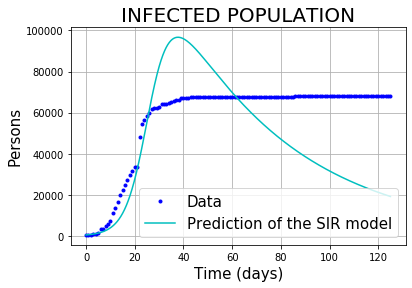

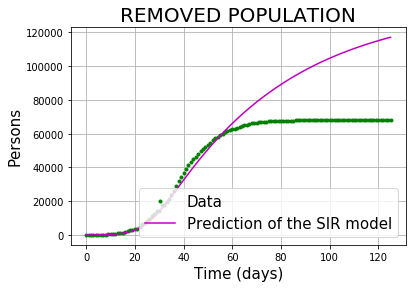

In [8]:
###################################
## Solution with odeint and Chi² ##
###################################

print('Solution with odeint and Chi²\n')

#Fit by chi²
N = max(data_confirmed + data_recovered + data_deaths)
steps = 10
beta = np.linspace(0.20,0.26,steps)
gamma = np.linspace(0.01,0.10,steps)
N = np.arange(N,N+steps)
shape = (steps,steps,steps)
chi2_S, chi2_I, chi2_R = np.zeros(shape), np.zeros(shape), np.zeros(shape)
for i in range(steps):
    for j in range(steps):
        for k in range(steps):
            #print('Calculating chi²:',i,j,k)
            sol = odeint(dydt,y0,time,args=(beta[i],gamma[j],N[k]))
            S_expected = sol[:,0]
            chi2_S[i,j,k] = Chi2(S,S_expected)
            I_expected = sol[:,1]
            chi2_I[i,j,k] = Chi2(I,I_expected)
            R_expected = sol[:,2]
            chi2_R[i,j,k] = Chi2(R,R_expected)

chi2_S_min, chi2_I_min, chi2_R_min = Min(chi2_S), Min(chi2_I), Min(chi2_R)
beta_opt = [0,0,0]
gamma_opt = [0,0,0]
N_opt = [0,0,0]
for i in range(steps):
    for j in range(steps):
        for k in range(steps):
            #print('Calculating minimum of chi²:',i,j,k)
            if chi2_S[i,j,k] == chi2_S_min:
                beta_opt[0], gamma_opt[0], N_opt[0] = beta[i], gamma[j], N[k]
            if chi2_I[i,j,k] == chi2_I_min:
                beta_opt[1], gamma_opt[1], N_opt[1] = beta[i], gamma[j], N[k]
            if chi2_R[i,j,k] == chi2_R_min:
                beta_opt[2], gamma_opt[2], N_opt[2] = beta[i], gamma[j], N[k]
                
beta = np.mean(beta_opt)
print('beta =',beta)
gamma = np.mean(gamma_opt)
print('gamma =',gamma)
N = int(np.mean(N_opt))
print('N =',N)

np.savetxt('beta_gamma_N_odeint.txt',[beta,gamma,N])

sol = odeint(dydt,y0,t,args=(beta,gamma,N))

plt.title('SUSCEPTIBLE POPULATION',fontsize=20)
plt.plot(time,S,'.r',label='Data')
plt.plot(t,sol[:,0],'k',label='Prediction of the SIR model')
plt.ylabel('Persons',fontsize=15)
plt.xlabel('Time (days)',fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.grid()
plt.show()

plt.title('INFECTED POPULATION',fontsize=20)
plt.plot(time,I,'.b',label='Data')
plt.plot(t,sol[:,1],'c',label='Prediction of the SIR model')
plt.ylabel('Persons',fontsize=15)
plt.xlabel('Time (days)',fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.grid()
plt.show()

plt.title('REMOVED POPULATION',fontsize=20)
plt.plot(time,R,'.g',label='Data')
plt.plot(t,sol[:,2],'m',label='Prediction of the SIR model')
plt.ylabel('Persons',fontsize=15)
plt.xlabel('Time (days)',fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.grid()
plt.show()

In [9]:
#################################
## Determining the best method ##
#################################

#Loading optimized parameters
parameter = np.array([np.loadtxt('beta_gamma_N_euler.txt'),
                      np.loadtxt('beta_gamma_N_rk4.txt'),
                      np.loadtxt('beta_gamma_N_odeint.txt')])

sol_euler = euler(dydt,y0,time,args=(parameter[0,0],parameter[0,1],parameter[0,2]))
sol_rk4 = rk4(dydt,y0,time,args=(parameter[1,0],parameter[1,1],parameter[1,2]))
sol_odeint = odeint(dydt,y0,time,args=(parameter[2,0],parameter[2,1],parameter[2,2]))

observed = np.append(S.reshape(len(S),1),I.reshape(len(I),1),axis=1)
observed = np.append(observed,R.reshape(len(R),1),axis=1)

chi2_euler = Chi2(observed,sol_euler)
chi2_rk4 = Chi2(observed,sol_rk4)
chi2_odeint = Chi2(observed,sol_odeint)

method = ['Euler','RK4','odeint']
chi2 = [chi2_euler, chi2_rk4, chi2_odeint]

print("The method with the lowest chi² is",method[chi2.index(min(chi2))])

The method with the lowest chi² is RK4


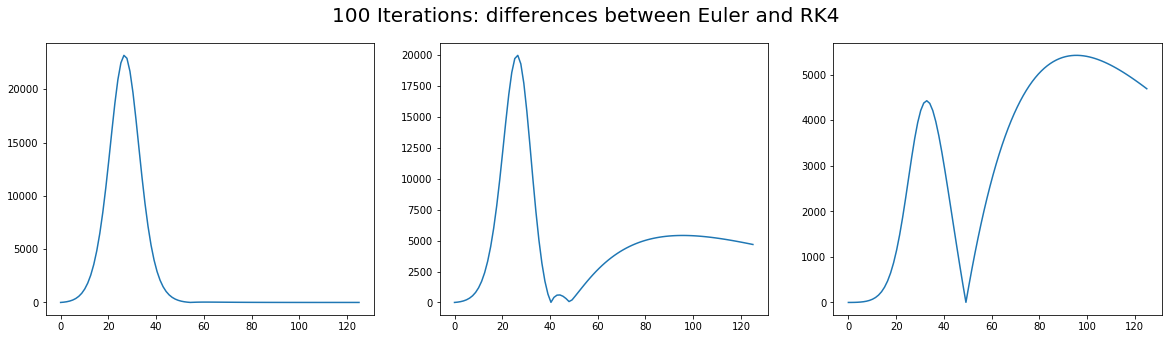

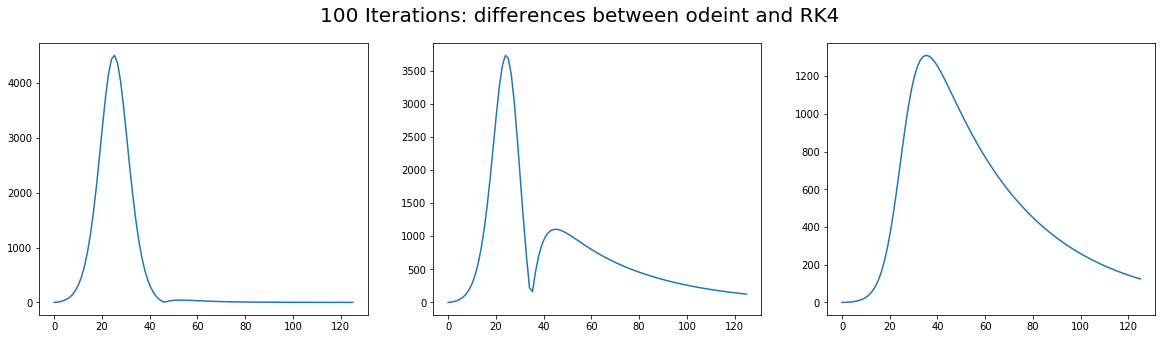

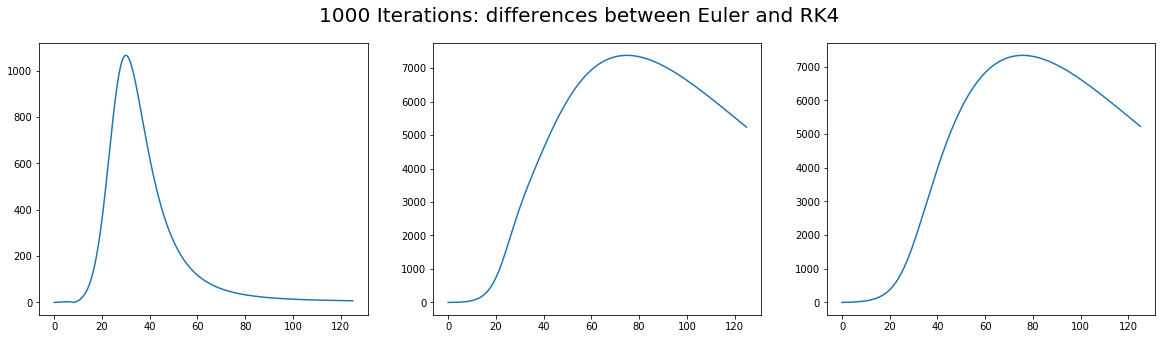

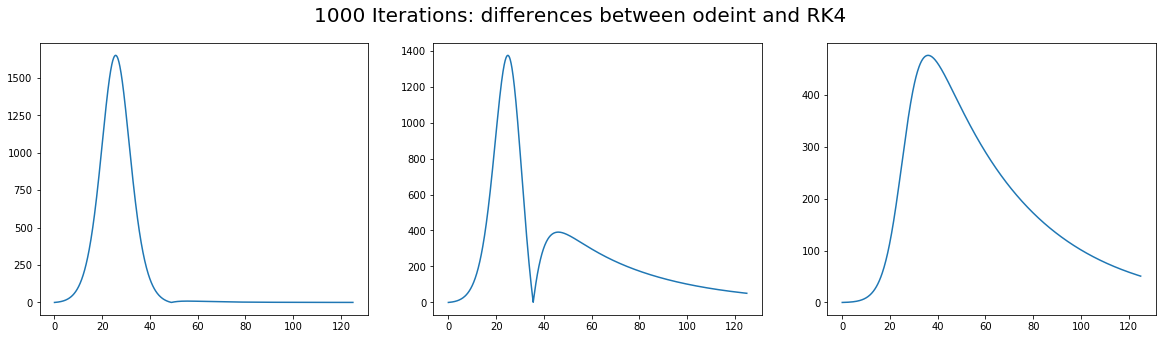

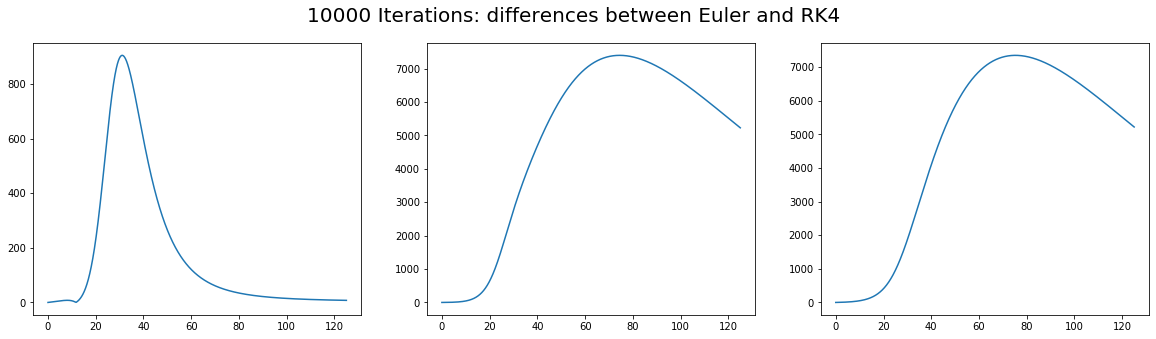

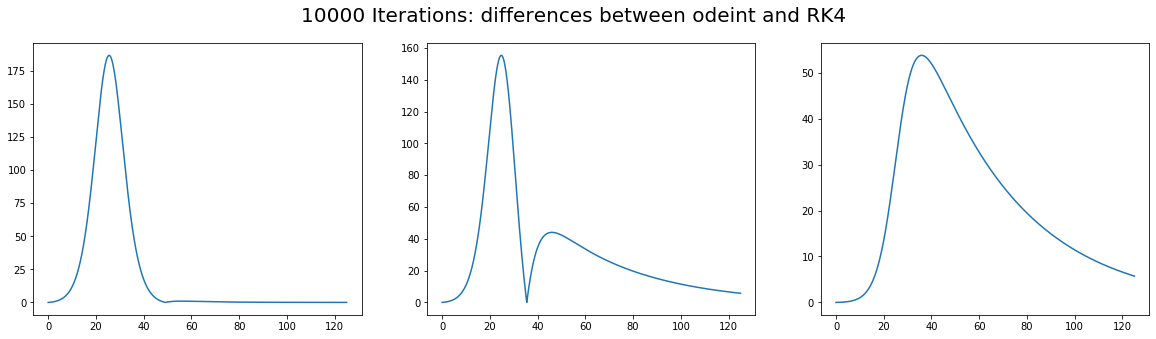

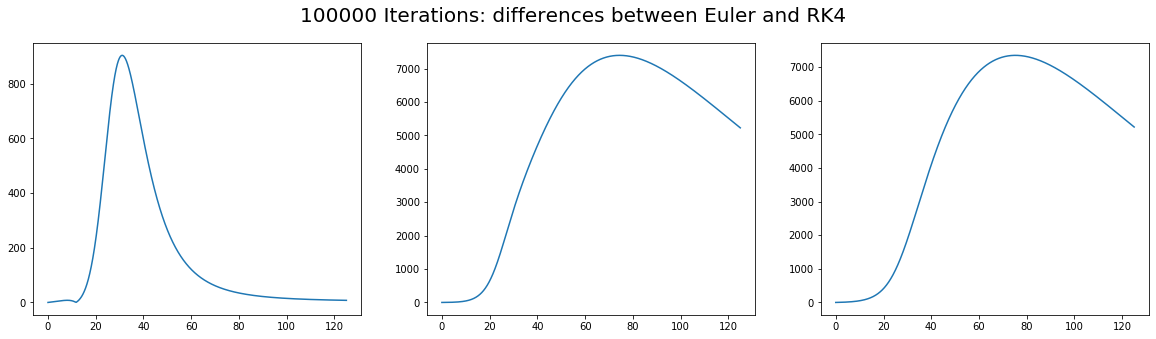

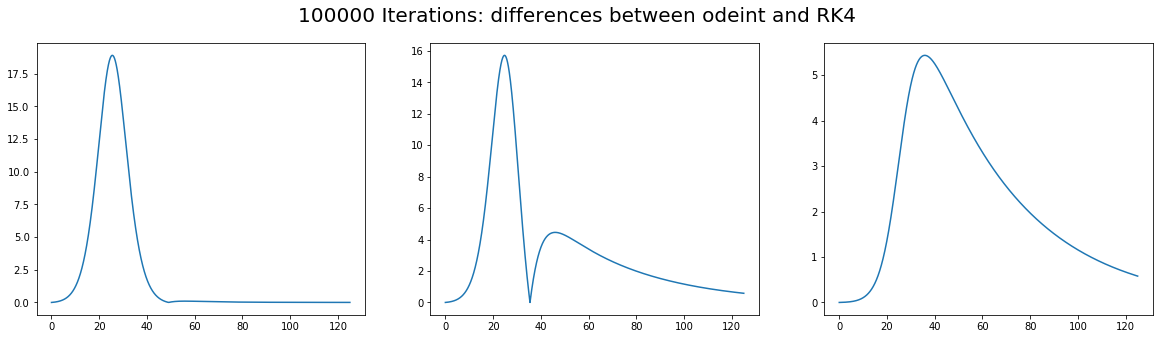

In [10]:
##########################
## Convergence analysis ##
##########################

partition = [100,1000,10000,100000]
for part in partition:
    t = np.linspace(time[0],time[-1],part)
    sol_euler = euler(dydt,y0,t,args=(parameter[0,0],parameter[0,1],parameter[0,2]))
    sol_rk4 = rk4(dydt,y0,t,args=(parameter[1,0],parameter[1,1],parameter[1,2]))
    sol_odeint = odeint(dydt,y0,t,args=(parameter[2,0],parameter[2,1],parameter[2,2]))
    diff_euler_rk4 = abs(sol_euler - sol_rk4)
    diff_odeint_rk4 = abs(sol_odeint - sol_rk4)
    
    plt.figure(figsize=(20,5))
    plt.suptitle(str(part)+' Iterations: differences between Euler and RK4',fontsize=20)
    plt.subplot(1,3,1)
    plt.plot(t,diff_euler_rk4[:,0])
    plt.subplot(1,3,2)
    plt.plot(t,diff_euler_rk4[:,1])
    plt.subplot(1,3,3)
    plt.plot(t,diff_euler_rk4[:,2])
    plt.show()
    
    plt.figure(figsize=(20,5))
    plt.suptitle(str(part)+' Iterations: differences between odeint and RK4',fontsize=20)
    plt.subplot(1,3,1)
    plt.plot(t,diff_odeint_rk4[:,0])
    plt.subplot(1,3,2)
    plt.plot(t,diff_odeint_rk4[:,1])
    plt.subplot(1,3,3)
    plt.plot(t,diff_odeint_rk4[:,2])
    plt.show()

Optimized values for the parameters of the system and the mean of them

beta = [0.22, 0.24, 0.26] beta mean = 0.24
gamma = [0.04000000000000001, 0.01, 0.01] gamma mean = 0.020000000000000004
N = [136274.0, 136265.0, 136265.0] N mean = 136268.0

Values of chi² for each triad of optimized parameters

[176900.7586644216, 11037947.836376522, 30034679.283970453, 3189824.1206204607]
[21951980.48769846, 691838.7382484473, 714658.6101090143, 2836632.8248257376]
[1487760.5382956318, 682335.5786326688, 505788.3919393992, 666425.4552063344]



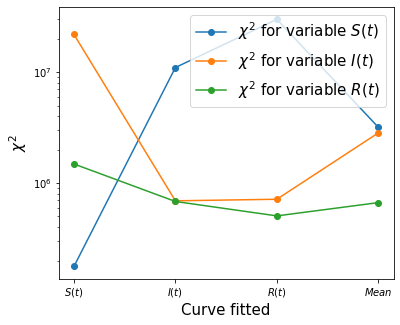

In [59]:
#################################################################################
## Dependence of infected and recovered with the free parameters of the system ##
#################################################################################

#Fit by chi²
N = max(data_confirmed + data_recovered + data_deaths)
steps = 10
beta = np.linspace(0.20,0.26,steps)
gamma = np.linspace(0.01,0.10,steps)
N = np.arange(N,N+steps)
shape = (steps,steps,steps)
chi2_S, chi2_I, chi2_R = np.zeros(shape), np.zeros(shape), np.zeros(shape)
for i in range(steps):
    for j in range(steps):
        for k in range(steps):
            #print('Calculating chi²:',i,j,k)
            sol = rk4(dydt,y0,time,args=(beta[i],gamma[j],N[k]))
            S_expected = sol[:,0]
            chi2_S[i,j,k] = Chi2(S,S_expected)
            I_expected = sol[:,1]
            chi2_I[i,j,k] = Chi2(I,I_expected)
            R_expected = sol[:,2]
            chi2_R[i,j,k] = Chi2(R,R_expected)

chi2_S_min, chi2_I_min, chi2_R_min = Min(chi2_S), Min(chi2_I), Min(chi2_R)
beta_opt = [0,0,0]
gamma_opt = [0,0,0]
N_opt = [0,0,0]
for i in range(steps):
    for j in range(steps):
        for k in range(steps):
            #print('Calculating minimum of chi²:',i,j,k)
            if chi2_S[i,j,k] == chi2_S_min:
                beta_opt[0], gamma_opt[0], N_opt[0] = beta[i], gamma[j], N[k]
            if chi2_I[i,j,k] == chi2_I_min:
                beta_opt[1], gamma_opt[1], N_opt[1] = beta[i], gamma[j], N[k]
            if chi2_R[i,j,k] == chi2_R_min:
                beta_opt[2], gamma_opt[2], N_opt[2] = beta[i], gamma[j], N[k]

print('Optimized values for the parameters of the system and the mean of them')
print('')
print('beta =',beta_opt,'beta mean =',np.mean(beta_opt))
print('gamma =',gamma_opt,'gamma mean =',np.mean(gamma_opt))
print('N =',N_opt,'N mean =',np.mean(N_opt))
print('')

sol_rk4 = [rk4(dydt,y0,time,args=(beta_opt[0],gamma_opt[0],N_opt[0])),
           rk4(dydt,y0,time,args=(beta_opt[1],gamma_opt[1],N_opt[1])),
           rk4(dydt,y0,time,args=(beta_opt[2],gamma_opt[2],N_opt[2])),
           rk4(dydt,y0,time,args=(np.mean(beta_opt),np.mean(gamma_opt),np.mean(N_opt)))]

chi2_S = []
chi2_I = []
chi2_R = []
for i in range(4):
    chi2_S.append(Chi2(S,sol_rk4[i][:,0]))
    chi2_I.append(Chi2(I,sol_rk4[i][:,1]))
    chi2_R.append(Chi2(R,sol_rk4[i][:,2]))
    
print('Values of chi² for each triad of optimized parameters')
print('')
print(chi2_S)
print(chi2_I)
print(chi2_R)
print('')

#Graphic
variable = ['$S(t)$','$I(t)$','$R(t)$','$Mean$']
plt.figure(figsize=(6,5))
plt.semilogy(variable,chi2_S,'-o',label='$\chi^2$ for variable $S(t)$')
plt.semilogy(variable,chi2_I,'-o',label='$\chi^2$ for variable $I(t)$')
plt.semilogy(variable,chi2_R,'-o',label='$\chi^2$ for variable $R(t)$')
plt.ylabel('$\chi^2$',fontsize=15)
plt.xlabel('Curve fitted',fontsize=15)
plt.legend(loc='best',fontsize=15)
#plt.grid()
plt.savefig('chi2_vs_curve_fitted.png')
plt.show()